# 目的
Kerasを用いた為替の予測をもう少し進める。   
`Test of Keras 2`の方で、勝率が高いと考えていたが、実はラベリングにミスがあるということに気づいた。  
たしかに時刻 $t+\tau$ で下がるか上がるかという情報を $t+\tau$ で渡していれば、確率も上がるのは当然だろう。   

このノートでは、修正されたラベリングを用いて、再度モデルと学習データを検討する。

In [1]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.models import model_from_json
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

import os
import pickle
import pandas as pd
import numpy as np
import datetime

from FX.FX import SQLAnaforFX
from FX.FX import drawfigfunc as dff
from FX.FX import datetimefuncs as dtf
from FX.FX import analyzefuncs as af
from FX.FX import KerasModelAdapter

Using TensorFlow backend.


## データの用意

In [2]:
"""ファイルの読み込み"""
fpath = "../../data/FXTF/USDJPY-cd1_20170806_k030.csv"
data = pd.read_csv(fpath, index_col=False)
data.head()

,date,time,open,high,low,close,sma07,sma13,sma25,volume,label1,label2,label3
0,2017.06.26,12:17,111.710,111.711,111.699,111.702,111.695000,111.694077,111.67924,44.0,0.0,0.0,1.0
1,2017.06.26,12:18,111.703,111.705,111.696,111.699,111.697143,111.693769,111.68092,36.0,0.0,0.0,1.0
2,2017.06.26,12:19,111.701,111.701,111.693,111.695,111.698571,111.693615,111.68260,39.0,0.0,0.0,1.0
3,2017.06.26,12:20,111.693,111.712,111.692,111.711,111.701143,111.695154,111.68484,52.0,0.0,0.0,1.0
4,2017.06.26,12:21,111.712,111.713,111.705,111.705,111.703571,111.696308,111.68688,45.0,0.0,0.0,1.0


In [42]:
"""OHLC"""
ohlc = data[["open", "high", "low", "close"]].as_matrix()
opens = data["open"].as_matrix()
high = data["high"].as_matrix()
low = data["low"].as_matrix()
close = data["close"].as_matrix()
volume = data["volume"].as_matrix()
oc = np.vstack((opens, close)).T

dclose = np.zeros_like(close)
dclose[1:] = np.diff(close)

"""Spread"""
s = 0.003

"""SMA"""
sma = data[["sma07", "sma13", "sma25"]].as_matrix()
sma = sma.T

## SMAを利用する場合、データの最初から数えてSMAの最大スパンまでのデータは利用しない方がよさそう。
sma_max_span = 25

"""Datetime"""
datetimes = []
datetime_fmt = "%Y.%m.%d %H:%M"
for date_t, time_t in zip(data["date"], data["time"]):
    datetime_str = date_t + " " + time_t
    datetime_t = datetime.datetime.strptime(datetime_str, datetime_fmt)
    datetimes.append(datetime_t)
datetimes = np.array([(datetimes[ii] - datetimes[0]).total_seconds()/60.**2 for ii in range(len(datetimes))])

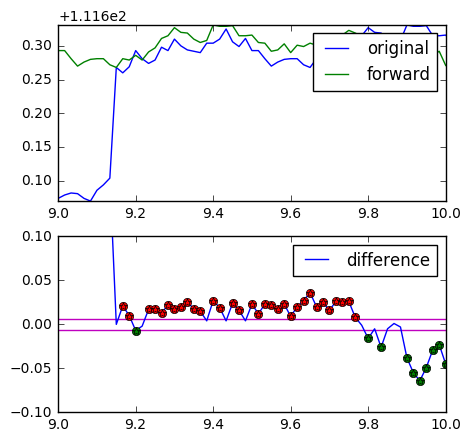

In [6]:
y_data = data[["label1","label2","label3"]].as_matrix()
y, diff = af.labeling(close, s*2, 30, 2)

xlim = [9, 10]

dff.makefig(5,5)
plt.subplot(211)
plt.plot(datetimes, close, label="original")

close_forward = np.zeros_like(close)
close_forward[:-30] = close[30:]
plt.plot(datetimes, close_forward, label="forward")
ind = (datetimes>= xlim[0])&(datetimes <= xlim[1])
plt.xlim(xlim)
plt.ylim([close[ind].min(), close[ind].max()])
plt.legend()

plt.subplot(212)
plt.plot(datetimes, diff, label="difference")
plt.plot(datetimes[y[:, 0]== 1], diff[y[:, 0]== 1], "ro")
plt.plot(datetimes[y[:, 2]== 1], diff[y[:, 2]== 1], "go")
plt.plot(datetimes[y_data[:, 0]== 1], diff[y_data[:, 0]== 1], "r*")
plt.plot(datetimes[y_data[:, 2]== 1], diff[y_data[:, 2]== 1], "g*")
plt.hlines([-s*2, s*2], datetimes[0], datetimes[-1], color="m")
plt.xlim(xlim)
plt.ylim(-0.1, 0.1)
plt.legend()


# closeのみ

In [7]:
def create_model(X, y):
    model = Sequential()
    
    # 入力層
    model.add(Dense(256, input_shape=(X.shape[1],)))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    # 中間層
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    # 出力層
    model.add(Dense(y.shape[1]))
    model.add(Activation('softmax'))

    # コンパイル
    model.compile(loss='categorical_crossentropy',
        optimizer="rmsprop",
        metrics=['accuracy'])
    
    return model

In [13]:
close_norm = close - close.mean()
X = close_norm / np.abs(close_norm).max()
X_train, X_test, y_train, y_test = train_test_split(X[:, None], y, test_size=0.3, random_state=90)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

model = create_model(X[:, None], y)

(29268, 1) (12544, 1) (29268, 3) (12544, 3)


In [14]:
# データで訓練 --- (※5)
hist = model.fit(
    X_train, y_train,
    batch_size=100,
    epochs=400,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2)],
    verbose=0)

# テストデータを用いて評価する --- (※6)
score = model.evaluate(X_test, y_test, verbose=0)
print('loss=', score[0])
print('accuracy=', score[1])

loss= 0.924430537437
accuracy= 0.455915178571


## もし高確率で予測されるもののみを取り出したら、正解率はどうなる？

まずは確率のヒストグラムをとる。

In [15]:
"""確率の取得"""
probs = model.predict_proba(X_test, verbose=0).T
labels = ["high", "lose", "low"]

"""確率のヒストグラムの作成"""
xbins = np.arange(0, 1.0, 0.05)
hists = np.zeros((3, len(xbins)))
for ii in range(len(probs)):
    hists[ii, :-1], bins = np.histogram(probs[ii], bins=xbins)
    hists[ii] /= hists[ii].sum()

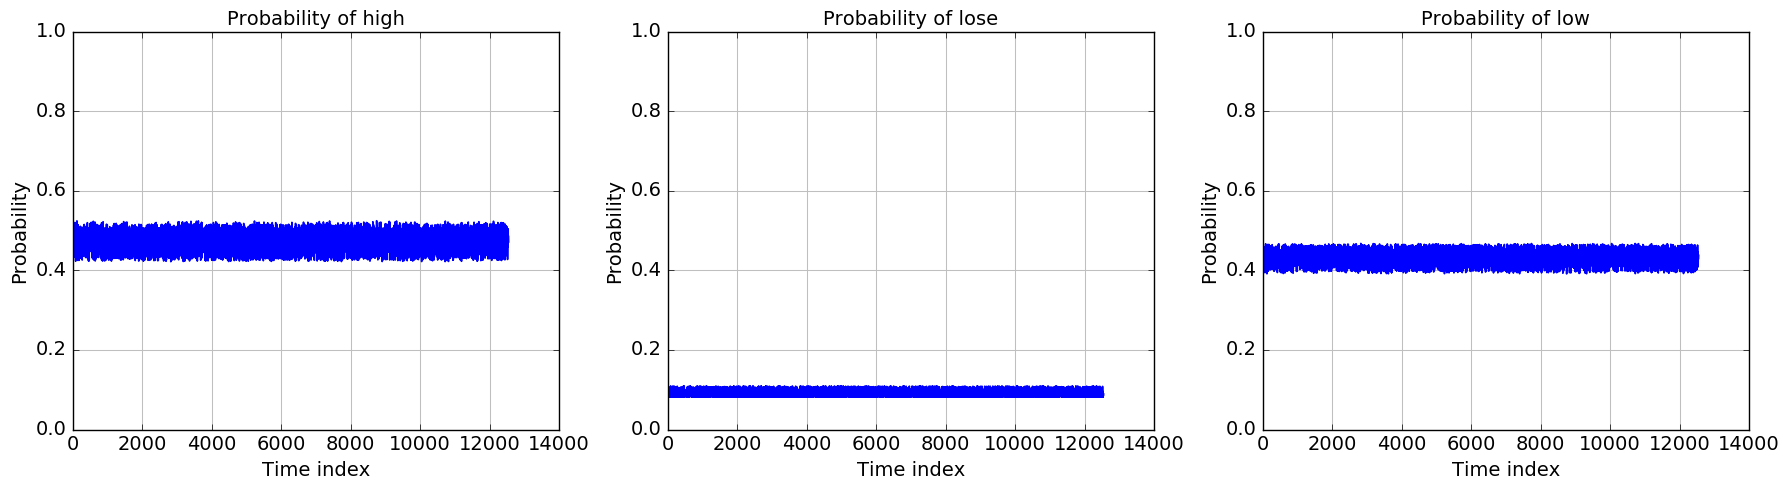

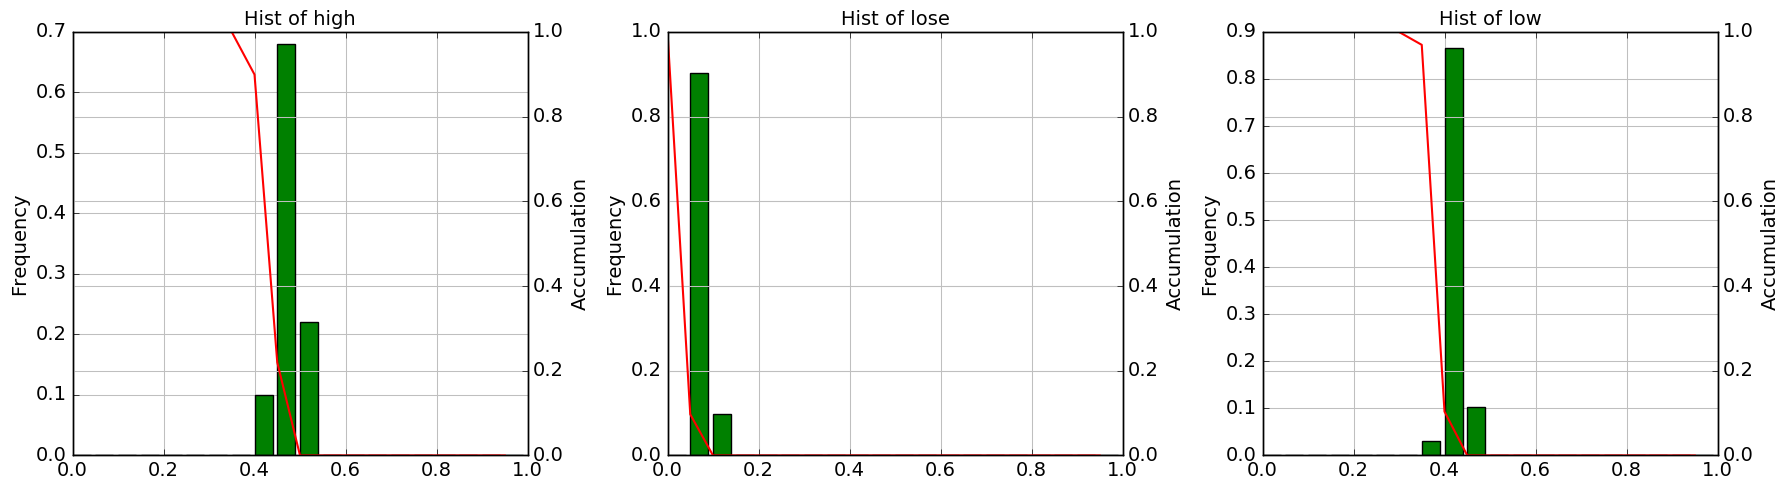

In [16]:
# 各ラベルに該当する確率
dff.makefig(18, 5)
for ii in range(len(probs)):
    plt.subplot(1,3,ii + 1)
    plt.plot(probs[ii], linewidth=1.2)
    dff.arrangefig(xlabel="Time index", ylabel="Probability", title="Probability of {}".format(labels[ii]))
    plt.ylim(0, 1)
plt.tight_layout()

# 各ラベルに該当する確率のヒストグラム
dff.makefig(18, 5)
dxbins = np.diff(xbins)[0]
for ii in range(len(hists)):
    plt.subplot(1,3,ii + 1)
    plt.bar(xbins, hists[ii], width=0.8*dxbins, hold="center", color="g")
    dff.arrangefig(ylabel="Frequency")
    ax2 = plt.gca().twinx()
    ax2.plot(xbins, 1.0 - np.cumsum(hists[ii]), "r-", linewidth=1.5)
    dff.arrangefig(xlabel="Probability", ylabel="Accumulation", title="Hist of {}".format(labels[ii]))
    plt.ylim(0, 1)
#     plt.yscale("log")
plt.tight_layout()

とりあえず60%以上を対象にするか。

In [17]:
prob_threshold = 0.6
probs = model.predict_proba(X_test, verbose=0).T
inds = np.zeros_like(probs, dtype=bool)
for ii in range(0, probs.shape[0]):
    inds[ii] = probs[ii] >= prob_threshold
ind_sum = inds.sum(axis=0) > 0
print("<# of events over threshold>")
print("[high, lose, low]:", inds.sum(axis=1), ",total:", ind_sum.sum())

# # テストデータを用いて評価する --- (※6)
score = model.evaluate(X_test[ind_sum], y_test[ind_sum], verbose=0)
print('loss=', score[0])
print('accuracy=', score[1])

<# of events over threshold>
[high, lose, low]: [0 0 0] ,total: 0


IndexError: list index out of range

# SMAを利用した場合

In [23]:
def create_model(X, y):
    model = Sequential()
    
    # 入力層
    model.add(Dense(256, input_shape=(X.shape[1],)))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    # 中間層
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    # 出力層
    model.add(Dense(y.shape[1]))
    model.add(Activation('softmax'))

    # コンパイル
    model.compile(loss='categorical_crossentropy',
        optimizer="rmsprop",
        metrics=['accuracy'])
    
    return model

In [24]:
# y, diff = af.labeling(close, 2*s, 30, 2)
y = y_data.copy()

sma_mean = sma.mean(axis=1)
sma_norm = np.zeros_like(sma)
for ii in range(sma.shape[0]):
    sma_norm[ii] = sma[ii] - sma_mean[ii]
    sma_norm[ii] /= np.abs(sma_norm[ii]).max()

X = sma_norm.T
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

model = create_model(X, y)

(29268, 3) (12544, 3) (29268, 3) (12544, 3)


In [25]:
# データで訓練 --- (※5)
hist = model.fit(
    X_train, y_train,
    batch_size=100,
    epochs=160, shuffle=False,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2)],
    verbose=0)

# テストデータを用いて評価する --- (※6)
score = model.evaluate(X_test, y_test, verbose=0)
print('loss=', score[0])
print('accuracy=', score[1])

loss= 0.918686856421
accuracy= 0.50318877551


## こちらでも高確率のもののみを取り出す

In [26]:
"""確率の取得"""
probs = model.predict_proba(X_test, verbose=0).T
labels = ["high", "lose", "low"]

"""確率のヒストグラムの作成"""
xbins = np.arange(0, 1.0, 0.05)
hists = np.zeros((3, len(xbins)))
for ii in range(len(probs)):
    hists[ii, :-1], bins = np.histogram(probs[ii], bins=xbins)
    hists[ii] /= hists[ii].sum()

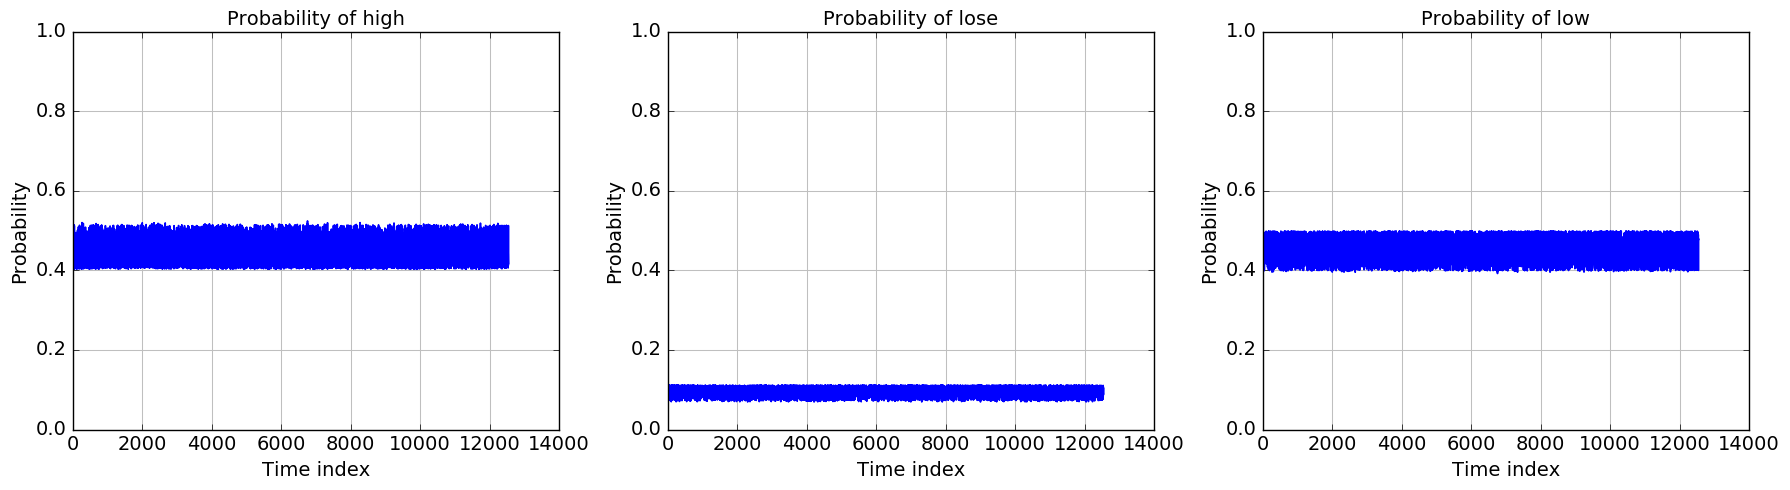

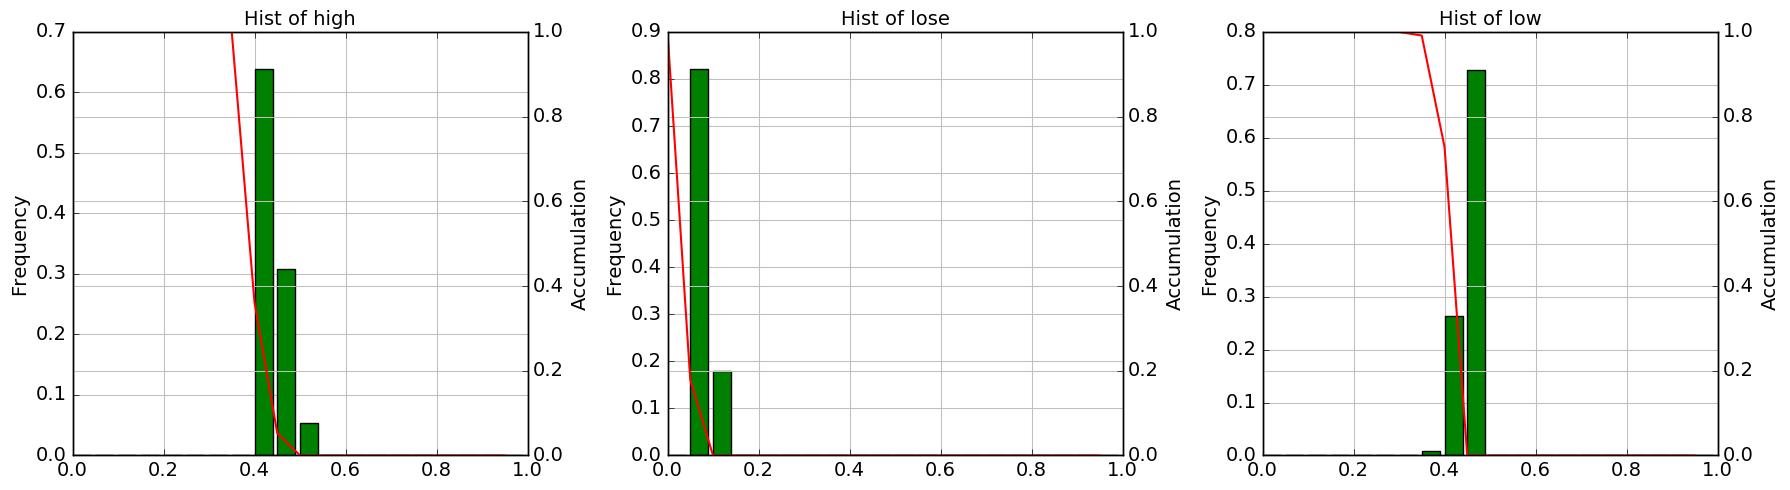

In [27]:
# 各ラベルに該当する確率
dff.makefig(18, 5)
for ii in range(len(probs)):
    plt.subplot(1,3,ii + 1)
    plt.plot(probs[ii], linewidth=1.2)
    dff.arrangefig(xlabel="Time index", ylabel="Probability", title="Probability of {}".format(labels[ii]))
    plt.ylim(0, 1)
plt.tight_layout()

# 各ラベルに該当する確率のヒストグラム
dff.makefig(18, 5)
dxbins = np.diff(xbins)[0]
for ii in range(len(hists)):
    plt.subplot(1,3,ii + 1)
    plt.bar(xbins, hists[ii], width=0.8*dxbins, hold="center", color="g")
    dff.arrangefig(ylabel="Frequency")
    ax2 = plt.gca().twinx()
    ax2.plot(xbins, 1.0 - np.cumsum(hists[ii]), "r-", linewidth=1.5)
    dff.arrangefig(xlabel="Probability", ylabel="Accumulation", title="Hist of {}".format(labels[ii]))
    plt.ylim(0, 1)
#     plt.yscale("log")
plt.tight_layout()

In [28]:
prob_threshold = 0.5 # 50%だと期待はできないが、、
probs = model.predict_proba(X_test, verbose=0).T
inds = np.zeros_like(probs, dtype=bool)
for ii in range(0, probs.shape[0]):
    inds[ii] = probs[ii] >= prob_threshold
ind_sum = inds.sum(axis=0) > 0
print("<# of events over threshold>")
print("[high, lose, low]:", inds.sum(axis=1), 
      ",total:", ind_sum.sum(),
      ", percentage:{0:.1f}".format(ind_sum.sum()*100./len(X_test)))

# # テストデータを用いて評価する --- (※6)
score = model.evaluate(X_test[ind_sum], y_test[ind_sum], verbose=0)
print('loss=', score[0])
print('accuracy=', score[1])

<# of events over threshold>
[high, lose, low]: [663   0   0] ,total: 663 , percentage:5.3
loss= 0.856009288431
accuracy= 0.579185520182


closeだけの場合と比べて下がっている？

# HLも加える
Openとcloseは等価であり、またSMAもcloseとほぼ等価である。   
ここではSMAにHigh/Lowを加えてみる。

In [32]:
# y, diff = af.labeling(close, 2*s, 30, 2)
# y = y[sma_max_span:]

hlsma = np.vstack((high, low, sma))
hlsma_mean = hlsma.mean(axis=1)
hlsma_norm = np.zeros_like(hlsma)
for ii in range(hlsma.shape[0]):
    hlsma_norm[ii] = hlsma[ii] - hlsma_mean[ii]
    hlsma_norm[ii] /= np.abs(hlsma_norm[ii]).max()

X = hlsma_norm.T
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

model = create_model(X, y)

(29268, 5) (12544, 5) (29268, 3) (12544, 3)


In [38]:
# データで訓練 --- (※5)
hist = model.fit(
    X_train, y_train,
    batch_size=100,
    epochs=800, shuffle=False,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2)],
    verbose=0)

# テストデータを用いて評価する --- (※6)
score = model.evaluate(X_test, y_test, verbose=0)
print('loss=', score[0])
print('accuracy=', score[1])

loss= 0.918737484332
accuracy= 0.498883928571


## こちらでも高確率のもののみを取り出す

In [39]:
"""確率の取得"""
probs = model.predict_proba(X_test, verbose=0).T
labels = ["high", "lose", "low"]

"""確率のヒストグラムの作成"""
xbins = np.arange(0, 1.0, 0.05)
hists = np.zeros((3, len(xbins)))
for ii in range(len(probs)):
    hists[ii, :-1], bins = np.histogram(probs[ii], bins=xbins)
    hists[ii] /= hists[ii].sum()

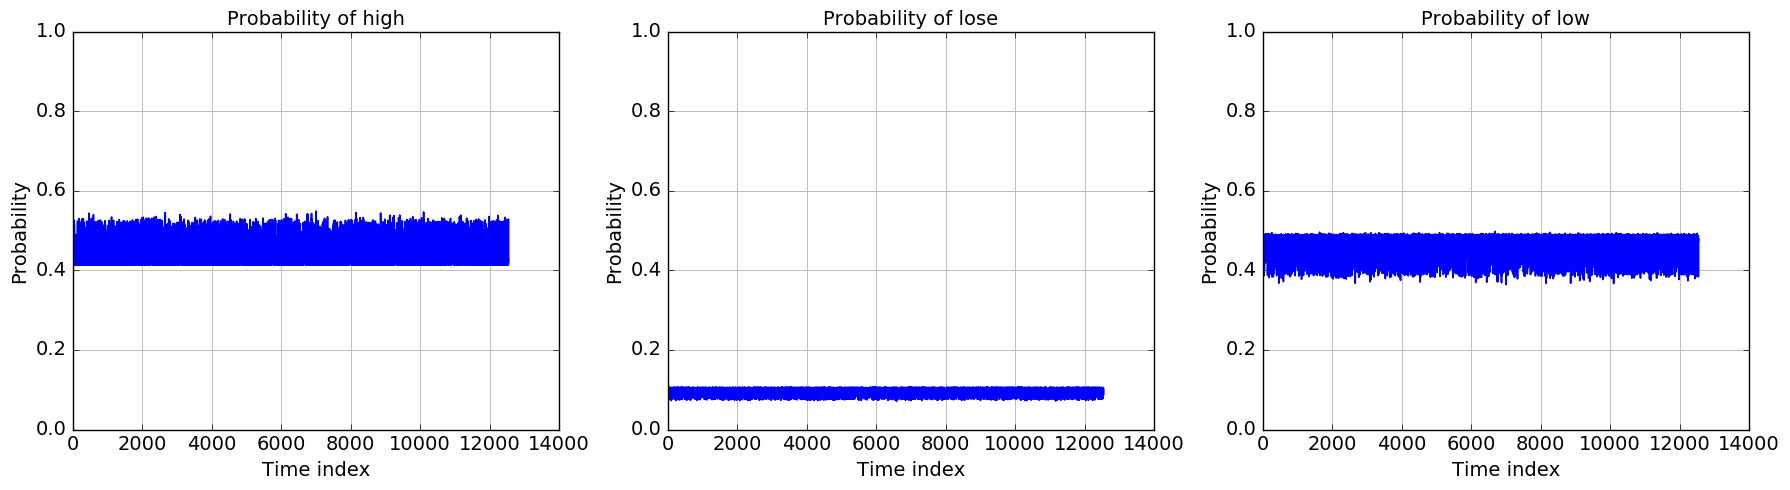

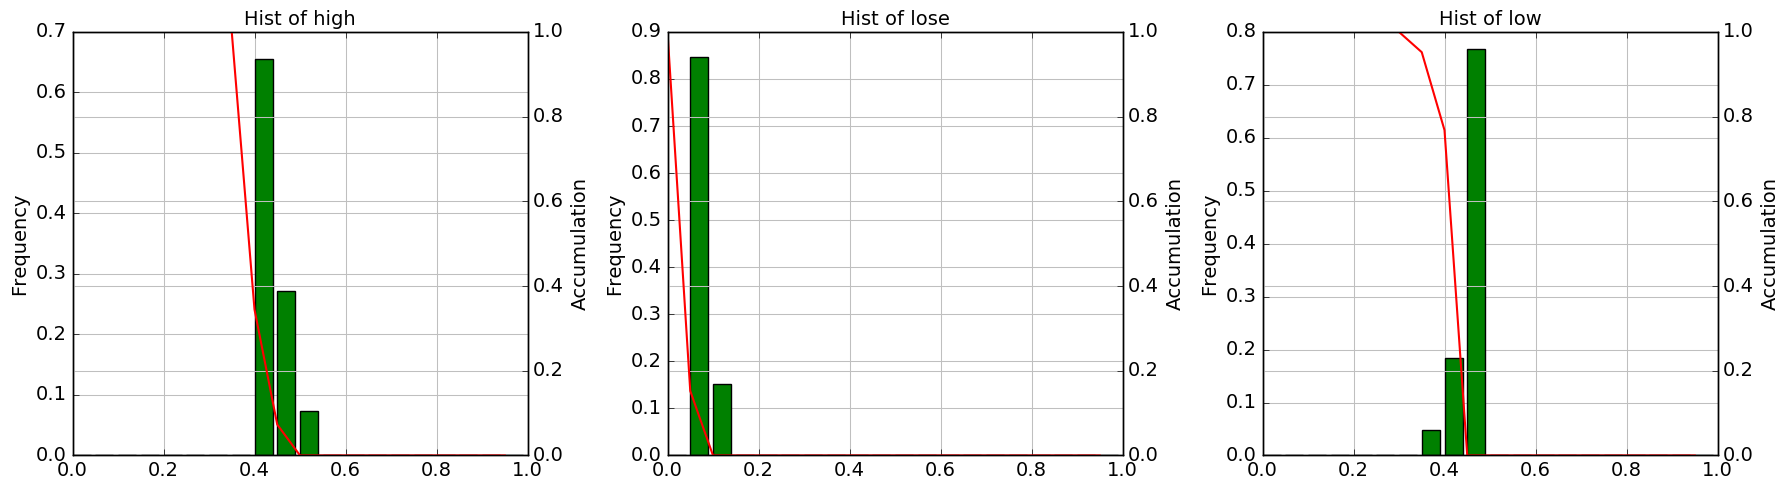

In [40]:
# 各ラベルに該当する確率
dff.makefig(18, 5)
for ii in range(len(probs)):
    plt.subplot(1,3,ii + 1)
    plt.plot(probs[ii], linewidth=1.2)
    dff.arrangefig(xlabel="Time index", ylabel="Probability", title="Probability of {}".format(labels[ii]))
    plt.ylim(0, 1)
plt.tight_layout()

# 各ラベルに該当する確率のヒストグラム
dff.makefig(18, 5)
dxbins = np.diff(xbins)[0]
for ii in range(len(hists)):
    plt.subplot(1,3,ii + 1)
    plt.bar(xbins, hists[ii], width=0.8*dxbins, hold="center", color="g")
    dff.arrangefig(ylabel="Frequency")
    ax2 = plt.gca().twinx()
    ax2.plot(xbins, 1.0 - np.cumsum(hists[ii]), "r-", linewidth=1.5)
    dff.arrangefig(xlabel="Probability", ylabel="Accumulation", title="Hist of {}".format(labels[ii]))
    plt.ylim(0, 1)
#     plt.yscale("log")
plt.tight_layout()

In [41]:
prob_threshold = 0.55
probs = model.predict_proba(X_test, verbose=0).T
inds = np.zeros_like(probs, dtype=bool)
for ii in range(0, probs.shape[0]):
    inds[ii] = probs[ii] >= prob_threshold
ind_sum = inds.sum(axis=0) > 0
print("<# of events over threshold>")
print("[high, lose, low]:", inds.sum(axis=1), 
      ",total:", ind_sum.sum(),
      ", percentage:{0:.1f}".format(ind_sum.sum()*100./len(X_test)))

# # テストデータを用いて評価する --- (※6)
score = model.evaluate(X_test[ind_sum], y_test[ind_sum], verbose=0)
print('loss=', score[0])
print('accuracy=', score[1])

<# of events over threshold>
[high, lose, low]: [0 0 0] ,total: 0 , percentage:0.0


IndexError: list index out of range

## まとめ
FXTFのデータを用いてテストしたが、k=30ではclose, SMA, HLSMAのどれも惨敗であった。   
連続する時間での値を用いるか、RNNを用いるか、別のkで試すなど、いくつか考えられるものはある。

## データの保存

In [81]:
adapter = KerasModelAdapter(model)

In [82]:
adapter.save("./data/model_20170601_2/")

In [86]:
adapter2 = KerasModelAdapter()
adapter2.load("./data/model_20170601/")

In [87]:
model2 = adapter2.model()

In [89]:
prob_threshold = 0.60
probs = model2.predict_proba(X, verbose=0).T
inds = np.zeros_like(probs, dtype=bool)
for ii in range(0, probs.shape[0]):
    inds[ii] = probs[ii] >= prob_threshold
ind_sum = inds.sum(axis=0) > 0
print("<# of events over threshold>")
print("[high, lose, low]:", inds.sum(axis=1), 
      ",total:", ind_sum.sum(),
      ", percentage:{0:.1f}".format(ind_sum.sum()*100./len(X)))

# # テストデータを用いて評価する --- (※6)
score = model2.evaluate(X[ind_sum], y[ind_sum], verbose=0)
print('loss=', score[0])
print('accuracy=', score[1])

<# of events over threshold>
[high, lose, low]: [  9   0 103] ,total: 112 , percentage:0.4
loss= 0.560678924833
accuracy= 0.875


# volumeも加えてみる

In [71]:
model = create_model(X, y)

In [93]:
hlsmav = np.vstack((high, low, sma, volume))
hlsmav_mean = hlsmav.mean(axis=1)
hlsmav_norm = np.zeros_like(hlsmav)
for ii in range(hlsmav.shape[0]):
    hlsmav_norm[ii] = hlsmav[ii] - hlsmav_mean[ii]
    hlsmav_norm[ii] /= np.abs(hlsmav_norm[ii]).max()

X = hlsmav_norm.T
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(29268, 6) (12544, 6) (29268, 3) (12544, 3)


In [94]:
# データで訓練 --- (※5)
hist = model.fit(
    X_train, y_train,
    batch_size=100,
    epochs=800, shuffle=False,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2)],
    verbose=0)

# テストデータを用いて評価する --- (※6)
score = model.evaluate(X_test, y_test, verbose=0)
print('loss=', score[0])
print('accuracy=', score[1])

loss= 0.918710890625
accuracy= 0.497767857143


In [95]:
"""確率の取得"""
probs = model.predict_proba(X_test, verbose=0).T
labels = ["high", "lose", "low"]

"""確率のヒストグラムの作成"""
xbins = np.arange(0, 1.0, 0.05)
hists = np.zeros((3, len(xbins)))
for ii in range(len(probs)):
    hists[ii, :-1], bins = np.histogram(probs[ii], bins=xbins)
    hists[ii] /= hists[ii].sum()

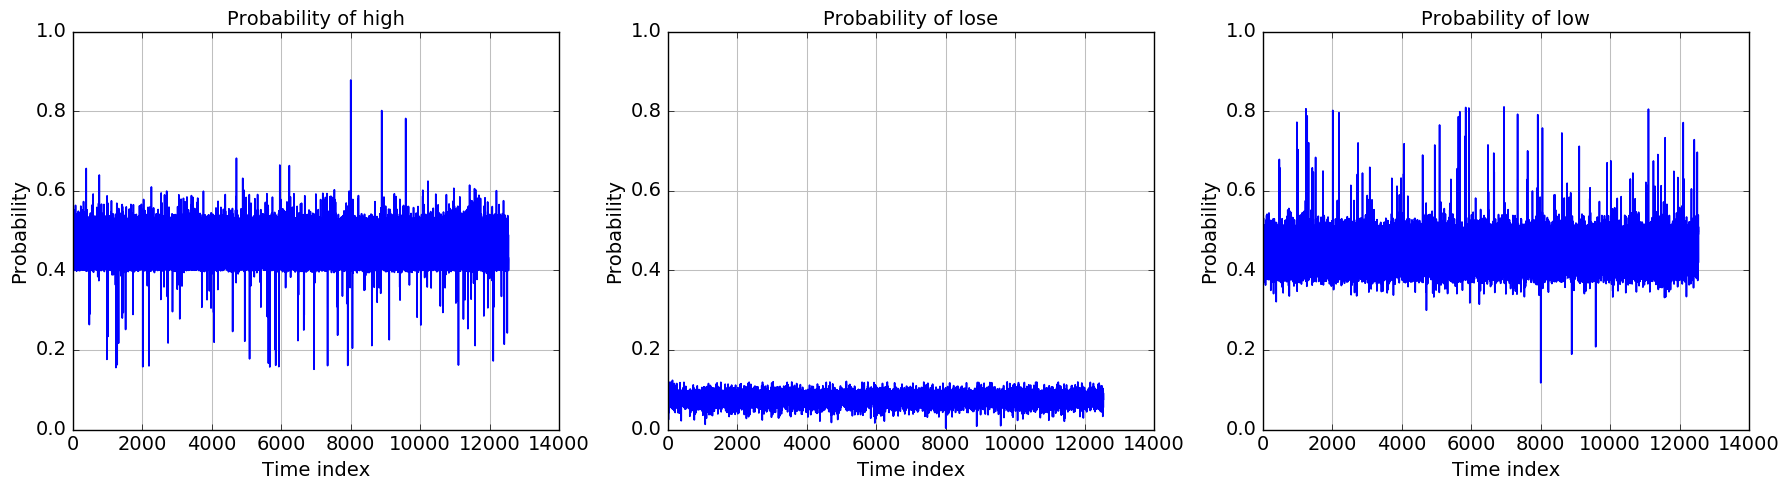

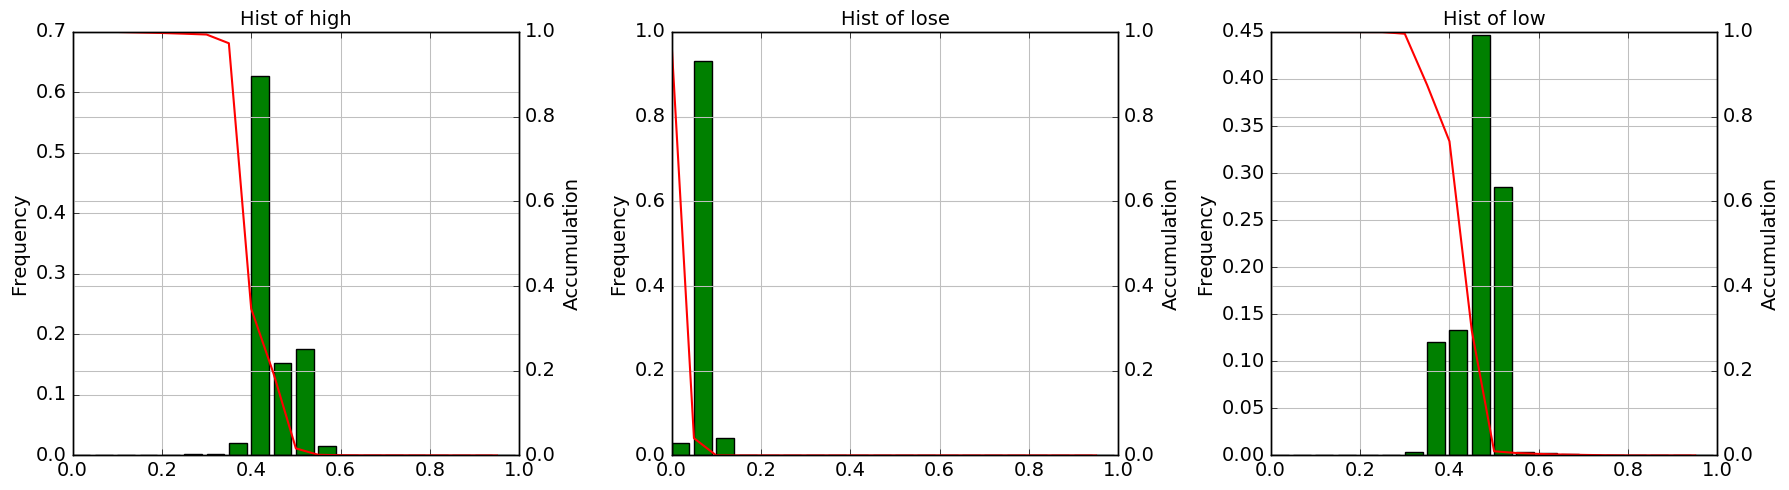

In [96]:
# 各ラベルに該当する確率
dff.makefig(18, 5)
for ii in range(len(probs)):
    plt.subplot(1,3,ii + 1)
    plt.plot(probs[ii], linewidth=1.2)
    dff.arrangefig(xlabel="Time index", ylabel="Probability", title="Probability of {}".format(labels[ii]))
    plt.ylim(0, 1)
plt.tight_layout()

# 各ラベルに該当する確率のヒストグラム
dff.makefig(18, 5)
dxbins = np.diff(xbins)[0]
for ii in range(len(hists)):
    plt.subplot(1,3,ii + 1)
    plt.bar(xbins, hists[ii], width=0.8*dxbins, hold="center", color="g")
    dff.arrangefig(ylabel="Frequency")
    ax2 = plt.gca().twinx()
    ax2.plot(xbins, 1.0 - np.cumsum(hists[ii]), "r-", linewidth=1.5)
    dff.arrangefig(xlabel="Probability", ylabel="Accumulation", title="Hist of {}".format(labels[ii]))
    plt.ylim(0, 1)
#     plt.yscale("log")
plt.tight_layout()

In [98]:
prob_threshold = 0.6
probs = model.predict_proba(X_test, verbose=0).T
inds = np.zeros_like(probs, dtype=bool)
for ii in range(0, probs.shape[0]):
    inds[ii] = probs[ii] >= prob_threshold
ind_sum = inds.sum(axis=0) > 0
print("<# of events over threshold>")
print("[high, lose, low]:", inds.sum(axis=1), 
      ",total:", ind_sum.sum(),
      ", percentage:{0:.2f}".format(ind_sum.sum()*100./len(X_test)))

# # テストデータを用いて評価する --- (※6)
score = model.evaluate(X_test[ind_sum], y_test[ind_sum], verbose=0)
print('loss=', score[0])
print('accuracy=', score[1])

<# of events over threshold>
[high, lose, low]: [19  0 72] ,total: 91 , percentage:0.73
loss= 0.933513867986
accuracy= 0.571428574704


## 所見
volumeを加えるとましになるが、それでも50%前後でしかない。   
同じデータセットでいくつかの分け方を行い訓練したが、スレッショルドを上げれば正答率が上がるという感じでもない。

# k値を変えてみる

In [139]:
"""ファイルの読み込み"""
fpath = "../../data/FXTF/USDJPY-cd1_20170806_k005.csv"
data = pd.read_csv(fpath, index_col=False)
data.head()

,date,time,open,high,low,close,sma07,sma13,sma25,volume,label1,label2,label3
0,2017.06.26,12:12,111.685,111.687,111.676,111.685,111.689143,111.688000,111.66944,55.0,1.0,0.0,0.0
1,2017.06.26,12:13,111.683,111.696,111.677,111.693,111.688571,111.690692,111.67132,61.0,1.0,0.0,0.0
2,2017.06.26,12:14,111.696,111.699,111.685,111.688,111.688143,111.692385,111.67324,44.0,1.0,0.0,0.0
3,2017.06.26,12:15,111.684,111.702,111.684,111.702,111.689857,111.693077,111.67500,44.0,1.0,0.0,0.0
4,2017.06.26,12:16,111.701,111.711,111.698,111.711,111.692857,111.694231,111.67732,32.0,0.0,0.0,1.0


In [140]:
"""OHLC"""
ohlc = data[["open", "high", "low", "close"]].as_matrix()
opens = data["open"].as_matrix()
high = data["high"].as_matrix()
low = data["low"].as_matrix()
close = data["close"].as_matrix()
volume = data["volume"].as_matrix()
oc = np.vstack((opens, close)).T

dclose = np.zeros_like(close)
dclose[1:] = np.diff(close)

"""Spread"""
s = 0.003

"""SMA"""
sma = data[["sma07", "sma13", "sma25"]].as_matrix()
sma = sma.T

## SMAを利用する場合、データの最初から数えてSMAの最大スパンまでのデータは利用しない方がよさそう。
sma_max_span = 25

"""Datetime"""
datetimes = []
datetime_fmt = "%Y.%m.%d %H:%M"
for date_t, time_t in zip(data["date"], data["time"]):
    datetime_str = date_t + " " + time_t
    datetime_t = datetime.datetime.strptime(datetime_str, datetime_fmt)
    datetimes.append(datetime_t)
datetimes = np.array([(datetimes[ii] - datetimes[0]).total_seconds()/60.**2 for ii in range(len(datetimes))])

In [154]:
model2 = create_model(X, y)

In [161]:
y = data[["label1","label2","label3"]].as_matrix()

hlsmav = np.vstack((high, low, sma, volume))
hlsmav_mean = hlsmav.mean(axis=1)
hlsmav_norm = np.zeros_like(hlsmav)
for ii in range(hlsmav.shape[0]):
    hlsmav_norm[ii] = hlsmav[ii] - hlsmav_mean[ii]
    hlsmav_norm[ii] /= np.abs(hlsmav_norm[ii]).max()

X = hlsmav_norm.T
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=70)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(29310, 6) (12562, 6) (29310, 3) (12562, 3)


In [162]:
# データで訓練 --- (※5)
hist = model.fit(
    X_train, y_train,
    batch_size=100,
    epochs=400, shuffle=False,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2)],
    verbose=0)

# テストデータを用いて評価する --- (※6)
score = model.evaluate(X_test, y_test, verbose=0)
print('loss=', score[0])
print('accuracy=', score[1])

loss= 1.048926253
accuracy= 0.41362840314


In [163]:
"""確率の取得"""
probs = model.predict_proba(X_test, verbose=0).T
labels = ["high", "lose", "low"]

"""確率のヒストグラムの作成"""
xbins = np.arange(0, 1.0, 0.05)
hists = np.zeros((3, len(xbins)))
for ii in range(len(probs)):
    hists[ii, :-1], bins = np.histogram(probs[ii], bins=xbins)
    hists[ii] /= hists[ii].sum()

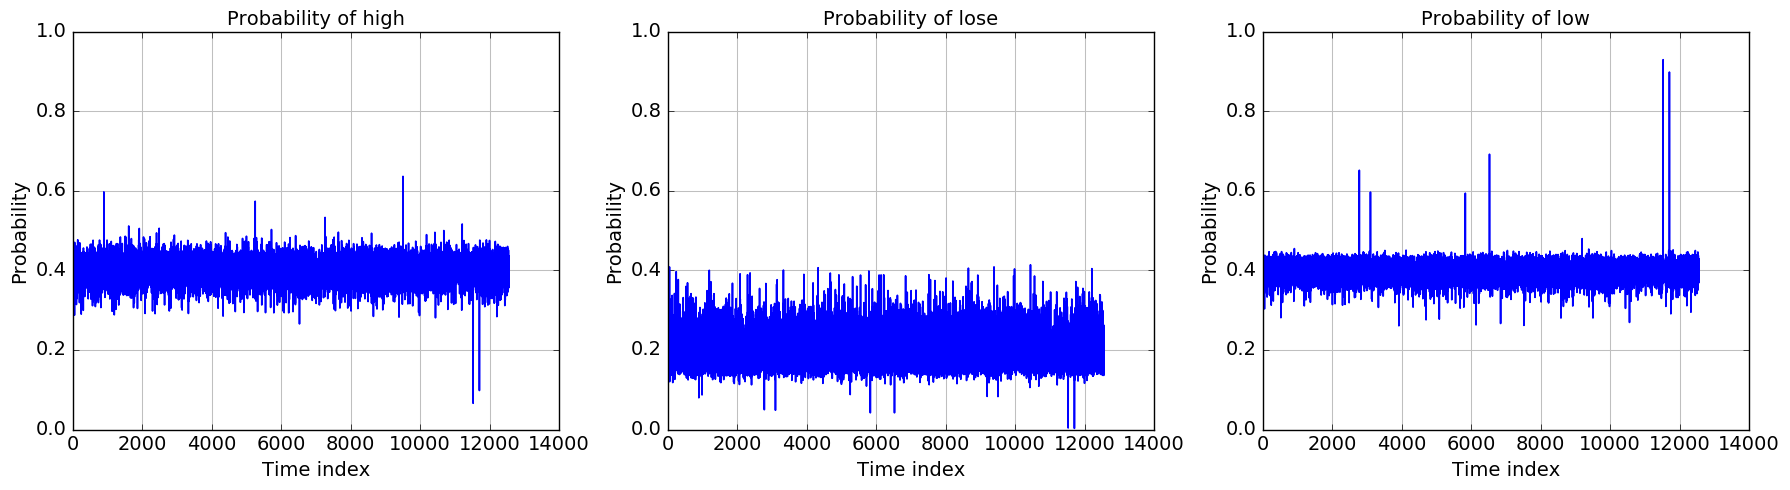

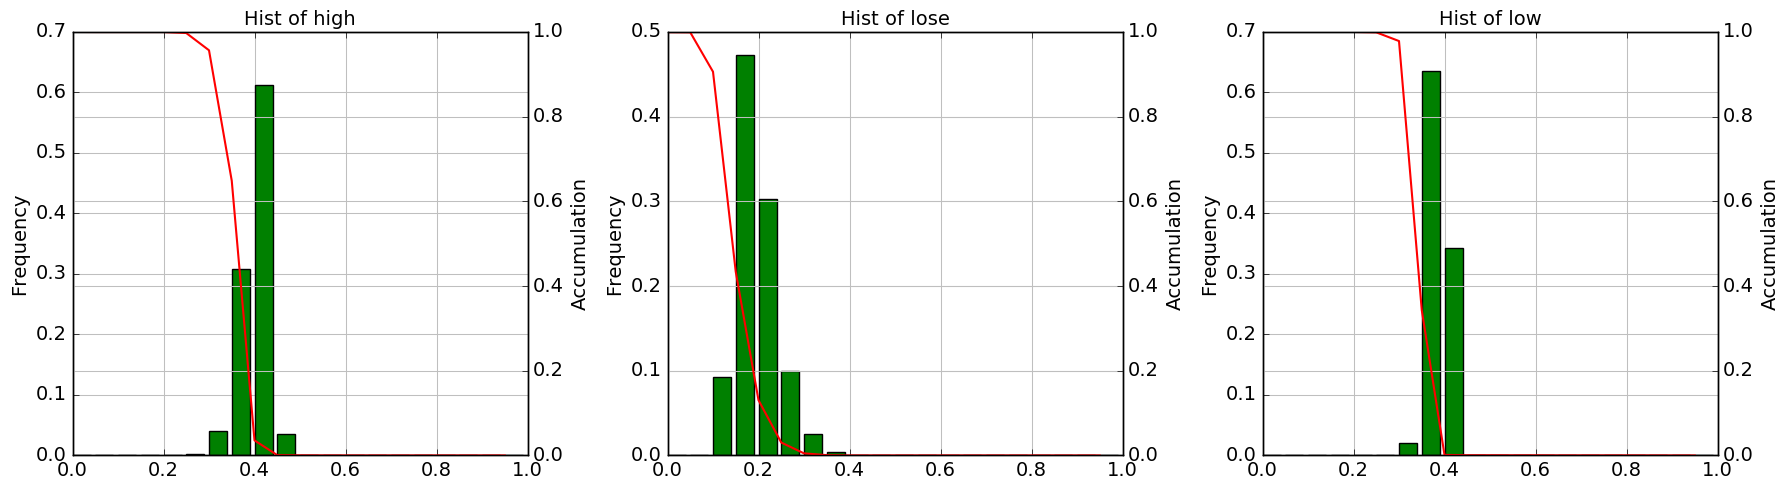

In [164]:
# 各ラベルに該当する確率
dff.makefig(18, 5)
for ii in range(len(probs)):
    plt.subplot(1,3,ii + 1)
    plt.plot(probs[ii], linewidth=1.2)
    dff.arrangefig(xlabel="Time index", ylabel="Probability", title="Probability of {}".format(labels[ii]))
    plt.ylim(0, 1)
plt.tight_layout()

# 各ラベルに該当する確率のヒストグラム
dff.makefig(18, 5)
dxbins = np.diff(xbins)[0]
for ii in range(len(hists)):
    plt.subplot(1,3,ii + 1)
    plt.bar(xbins, hists[ii], width=0.8*dxbins, hold="center", color="g")
    dff.arrangefig(ylabel="Frequency")
    ax2 = plt.gca().twinx()
    ax2.plot(xbins, 1.0 - np.cumsum(hists[ii]), "r-", linewidth=1.5)
    dff.arrangefig(xlabel="Probability", ylabel="Accumulation", title="Hist of {}".format(labels[ii]))
    plt.ylim(0, 1)
#     plt.yscale("log")
plt.tight_layout()

In [165]:
prob_threshold = 0.6
probs = model.predict_proba(X_test, verbose=0).T
inds = np.zeros_like(probs, dtype=bool)
for ii in range(0, probs.shape[0]):
    inds[ii] = probs[ii] >= prob_threshold
ind_sum = inds.sum(axis=0) > 0
print("<# of events over threshold>")
print("[high, lose, low]:", inds.sum(axis=1), 
      ",total:", ind_sum.sum(),
      ", percentage:{0:.2f}".format(ind_sum.sum()*100./len(X_test)))

# # テストデータを用いて評価する --- (※6)
score = model.evaluate(X_test[ind_sum], y_test[ind_sum], verbose=0)
print('loss=', score[0])
print('accuracy=', score[1])

<# of events over threshold>
[high, lose, low]: [1 0 4] ,total: 5 , percentage:0.04
loss= 1.16991770267
accuracy= 0.40000000596


In [166]:
prob_threshold = 0.6
probs = model.predict_proba(X, verbose=0).T
inds = np.zeros_like(probs, dtype=bool)
for ii in range(0, probs.shape[0]):
    inds[ii] = probs[ii] >= prob_threshold
ind_sum = inds.sum(axis=0) > 0
print("<# of events over threshold>")
print("[high, lose, low]:", inds.sum(axis=1), 
      ",total:", ind_sum.sum(),
      ", percentage:{0:.2f}".format(ind_sum.sum()*100./len(X)))

score = model.evaluate(X[ind_sum], y[ind_sum], verbose=0)
print('loss=', score[0])
print('accuracy=', score[1])

<# of events over threshold>
[high, lose, low]: [ 5  0 12] ,total: 17 , percentage:0.04
loss= 0.705354869366
accuracy= 0.764705896378


## 所見
k=5,30,60,120、データ分割の種を8,300として訓練した。   

* k=120はスレッショルドを超える頻度が大きい一方でスレッショルドを上げたときの正答率が下がる。
* k=5はスレッショルドを超える頻度が非常に小さいが、正答率は高い？（サンプルが少なすぎる。）

次は連続したデータをいれてみるか。。